In [1]:
import torch 
import matplotlib.pyplot as plt
import numpy as np

/Users/advaitgadhikar/opt/anaconda3/envs/experiments/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [58]:
!pip install folktables

In [2]:
from folktables import ACSDataSource, ACSEmployment

data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["AL"], download=True)
features, label, group = ACSEmployment.df_to_numpy(acs_data)

(38221, 16) (38221,)


(array([22583.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 15638.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

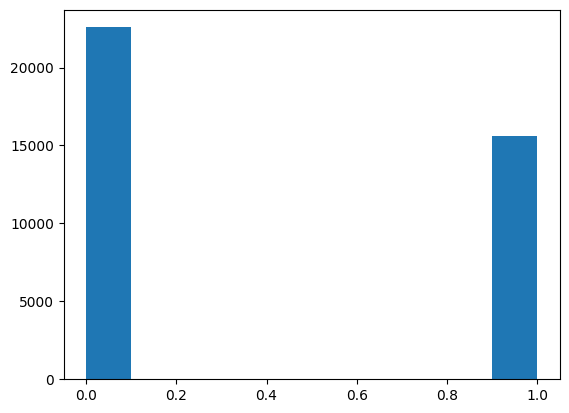

In [3]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    features, label, group, test_size=0.2, random_state=0)

print(X_train.shape, y_train.shape)
plt.hist(y_train.astype(int))

In [4]:
import pandas as pd

from folktables import ACSDataSource, ACSIncome

data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
ca_data = data_source.get_data(states=["CA"], download=True)

ca_features, ca_labels, _ = ACSIncome.df_to_pandas(ca_data)

ca_features.to_csv('ca_features.csv', index=False)
ca_labels.to_csv('ca_labels.csv', index=False)



In [5]:
ca_features = np.array(ca_features)
ca_labels = np.array(ca_labels).astype(int).squeeze()
print(ca_features.shape)


(195665, 10)


In [6]:
from torchvision import datasets, transforms

import torch.multiprocessing
from torch.utils.data import Dataset
import math
# import h5py
import os
from torch.utils.data import DataLoader

class Fairness(Dataset):

    def __init__(self, X_train, X_test, y_train, y_test, train = True):
        if train:
            self.data = X_train
            self.labels = y_train
        else:
            self.data = X_test
            self.labels = y_test
            
    def __len__(self):
        return self.data.shape[0]


    def __getitem__(self, index):
        return self.data[index,:], self.labels[index].squeeze()

train_dataset = Fairness(X_train, X_test, y_train, y_test, train=True)
val_dataset = Fairness(X_train, X_test, y_train, y_test, train=False)



trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
testloader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [7]:
import math
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.nn import init
from torch.nn.parameter import Parameter

class LinearER(nn.Linear):
    def __init__(self, in_features, out_features, bias=True):
        super(LinearER, self).__init__(in_features, out_features, bias)
        self.register_buffer('weight_mask', torch.ones(self.weight.shape))
        if self.bias is not None:
            self.register_buffer('bias_mask', torch.ones(self.bias.shape))
    
    
    def forward(self, input):
        self.weight_mask = self.weight_mask.to(self.weight.device)
        W = self.weight_mask * self.weight
        if self.bias is not None:
            b = self.bias_mask * self.bias
        else:
            b = self.bias
        return F.linear(input, W, b)


In [8]:
class ToyModel(nn.Module):
    def __init__(self, nin = 16, nout = 2, width = 256):
        
        super(ToyModel, self).__init__()
        
        self.linear1 = LinearER(nin, width)
        self.linear2 = LinearER(width, width)
        self.linear3 = LinearER(width, width)
        self.linear4 = LinearER(width, nout)
        self.bn1 = nn.BatchNorm1d(width)
        self.bn2 = nn.BatchNorm1d(width)
        self.bn3 = nn.BatchNorm1d(width)
        
    def forward(self, x):
        x = self.bn1(F.relu(self.linear1(x)))
        x = self.bn2(F.relu(self.linear2(x)))        
        x = self.bn3(F.relu(self.linear3(x)))        
        x = (self.linear4(x))
        return x

In [9]:
def prune_mag(model, density):
    score_list = {}
    for n, m in model.named_modules():
        # torch.cat([torch.flatten(v) for v in self.scores.values()])
        if isinstance(m, (nn.Linear)):
            score_list[n] = (m.weight_mask.to(m.weight.device) * m.weight).detach().abs_()

    global_scores = torch.cat([torch.flatten(v) for v in score_list.values()])
    k = int((1 - density) * global_scores.numel())
    threshold, _ = torch.kthvalue(global_scores, k)

    if not k < 1:
        total_num = 0
        total_den = 0
        for n, m in model.named_modules():
            if isinstance(m, (nn.Linear)):
                score = score_list[n].to(m.weight.device)
                zero = torch.tensor([0.]).to(m.weight.device)
                one = torch.tensor([1.]).to(m.weight.device)
                m.weight_mask = torch.where(score <= threshold, zero, one)
                total_num += (m.weight_mask == 1).sum()
                total_den += m.weight_mask.numel()

    print('Overall model density after magnitude pruning at current iteration = ', total_num / total_den)
    return model

def prune_random(model, density):
    total_num = 0
    total_den = 0

    for n, m in model.named_modules():
        if isinstance(m, (nn.Linear)):
            score = (m.weight_mask.to(m.weight.device) * torch.randn_like(m.weight).to(m.weight.device)).detach().abs_()
            global_scores = torch.flatten(score)
            k = int((1 - density) * global_scores.numel())
            if k == 0:
                threshold = 0
            else: 
                threshold, _ = torch.kthvalue(global_scores, k)
            print('Layer', n, ' params ', k, global_scores.numel())

            score = score.to(m.weight.device)
            zero = torch.tensor([0.]).to(m.weight.device)
            one = torch.tensor([1.]).to(m.weight.device)
            m.weight_mask = torch.where(score <= threshold, zero, one)
            total_num += (m.weight_mask == 1).sum()
            total_den += m.weight_mask.numel()
    print('Overall model density after magnitude pruning at current iteration = ', total_num / total_den)
    return model

In [10]:
import pathlib
import time
def write_result_to_csv(**kwargs):
    filename = 'tabular_results.csv'
    base_dir = ''

    results = pathlib.Path(base_dir, filename)
    
    if not results.exists():
        print('creating and opening a results file')
        with open(results, 'w', newline=''):

            results.write_text(
                "Name,"
                "Best Val Top 1, "
                "Sparsity\n"
            )

    now = time.strftime("%m-%d-%y_%H:%M:%S")

    with open(results, "a+") as f:
        f.write(
            (
            "{name},"
            "{best_acc1:.04f},"
            "{sparsity:.04f}\n"
            ).format(**kwargs)
        )

In [11]:
import torch.optim as optim
import copy

def run(pruner, threshold_list, name, er = 0.5, reset_weight=False):
    model = ToyModel(width = 256)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr = 1e-2)
    
    #init ER density is 1.0 i.e starting from a ful dense network
    density = er

    torch.save(model.state_dict(),"model_tabular.pt")
    torch.save(optimizer.state_dict(),"optimizer_tabular.pt")

    for n,m in model.named_modules():
        if isinstance(m, nn.Linear):
            m.weight_mask = torch.zeros_like(m.weight).bernoulli_(p = density)

    # threshold_list = [0.4]
    test_acc = []
    for d in threshold_list:
        for epoch in range(10):  # loop over the dataset multiple times

            running_loss = 0.0
            model.train()
            for i, (inputs, labels) in enumerate(trainloader, 0):
                # get the inputs; data is a list of [inputs, labels]
                inputs, labels = inputs.to(torch.float32), labels.long()
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward + backward + optimize
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                # print statistics
                running_loss += loss.item()
                if i % 100 == 99:    # print every 2000 mini-batches
                    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
                    running_loss = 0.0

            model.eval()
            val_acc = 0
            val_loss = 0
            cnt = 0
            for i, (inputs, labels) in enumerate(testloader):
                inputs, labels = inputs.to(torch.float32), labels.long()
                preds = model(inputs)
                # print(preds.argmax(dim=1), labels)
                # print(preds)
                val_loss += criterion(preds, labels)
                val_acc += (preds.argmax(dim=1) == labels).sum() / preds.shape[0]
                cnt += 1
            val_acc = val_acc / cnt
            val_loss = val_loss / cnt

            print('Validation loss and acc: ', val_loss.item(), val_acc.item())
            test_acc.append(val_acc)

        # model = prune_mag(model, d)
        # print('pruned model at density: ', d)
        model_before_prune = copy.deepcopy(model)
        
        if pruner == 'random':
            model = prune_random(model, d)
            print('pruned randomly model at density: ', d)
        if pruner == 'mag':
            model = prune_mag(model, d)
            print('pruned model by magnitude at density: ', d)
        # reset weights
        if reset_weight:
            original_dict = torch.load("model_tabular.pt")
            original_weights = dict(filter(lambda v: (v[0].endswith(('.weight', '.bias'))), original_dict.items()))
            model_dict = model.state_dict()
            model_dict.update(original_weights)
            model.load_state_dict(model_dict)

            # Reset Optimizer and Scheduler
            optimizer.load_state_dict(torch.load("optimizer_tabular.pt"))
            print('Weights of the model reset to initialization weights')


    model_sparse = copy.deepcopy(model)

    for epoch in range(20):  # loop over the dataset multiple times

        running_loss = 0.0
        model.train()
        for i, (inputs, labels) in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = inputs.to(torch.float32), labels.long()
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 100 == 99:    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
                running_loss = 0.0

        model.eval()
        val_acc = 0
        val_loss = 0
        cnt = 0
        for i, (inputs, labels) in enumerate(testloader):
            inputs, labels = inputs.to(torch.float32), labels.long()
            preds = model(inputs)
            # print(preds.argmax(dim=1), labels)
            # print(preds)
            val_loss += criterion(preds, labels)
            val_acc += (preds.argmax(dim=1) == labels).sum() / preds.shape[0]
            cnt += 1
        val_acc = val_acc / cnt
        val_loss = val_loss / cnt
        test_acc.append(val_acc)

        print('Validation loss and acc: ', val_loss.item(), val_acc.item())
    print('Finished Training')
    total_num = 0
    total_den = 0
    for n, m in model.named_modules():
        if isinstance(m, (nn.Linear)):
            total_num += m.weight_mask.sum()
            total_den += m.weight.numel()
            
    model_final = copy.deepcopy(model)
    best_acc1 = np.array(test_acc).max()
    sparsity = 1 - (total_num / total_den)
    write_result_to_csv(
        name = name,
        best_acc1 = best_acc1,
        sparsity = sparsity,
    )
    return model, criterion, inputs, labels, model_final, model_before_prune, model_sparse

In [19]:
name = ['imp']
start_density = [0.8, 0.4]
target_density = [0.1]
er_list = [1, 0.5]
cnt = 1
for n in name:
    for d in target_density:
        threshold_list = []
        s = start_density[cnt]
        while s >= d:
            threshold_list.append(s)
            s = s - 0.1
        print(threshold_list)
        exp_name = n + '-' + str(er_list[cnt]) + '-'+ str(d) 
        if n == 'imp' or n == 'finetune':
            pruner = 'mag'
        
        print(exp_name)
        model, criterion, inputs, labels, model_final, model_before_prune, model_sparse = run(pruner = pruner, threshold_list = threshold_list, name=exp_name, er=er_list[cnt], reset_weight=False)
        cnt += 1

[0.4, 0.30000000000000004, 0.20000000000000004, 0.10000000000000003]
imp-0.5-0.1
[1,   100] loss: 0.024
[1,   200] loss: 0.022
[1,   300] loss: 0.021
[1,   400] loss: 0.021
[1,   500] loss: 0.021
Validation loss and acc:  0.4315219521522522 0.792229175567627
[2,   100] loss: 0.021
[2,   200] loss: 0.020
[2,   300] loss: 0.022
[2,   400] loss: 0.021
[2,   500] loss: 0.020
Validation loss and acc:  0.42244836688041687 0.8007708191871643
[3,   100] loss: 0.021
[3,   200] loss: 0.021
[3,   300] loss: 0.020
[3,   400] loss: 0.021
[3,   500] loss: 0.020
Validation loss and acc:  0.4161424934864044 0.7973541617393494
[4,   100] loss: 0.020
[4,   200] loss: 0.020
[4,   300] loss: 0.020
[4,   400] loss: 0.021
[4,   500] loss: 0.020
Validation loss and acc:  0.4362751841545105 0.7943541407585144
[5,   100] loss: 0.021
[5,   200] loss: 0.021
[5,   300] loss: 0.020
[5,   400] loss: 0.020
[5,   500] loss: 0.021
Validation loss and acc:  0.4350973069667816 0.8146249651908875
[6,   100] loss: 0.021
[